# Solution for Assignment 2
## Image Mosaicing(Image Stitching)

### Problem
   Given n images of same scene from different viewpoints, stitch those images together.

### Procedure
   - Points and Feature Detection
   - Matching
   - Hommography
   - Stitch 2 images
   
### Images
    1. img1_* => hill 
    2. img2_* => taj mahal
    3. img3_* => cactus
    4. img4_* => text
      

In [1]:
# Imports 
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Dirs 
test_dir = './test_images/'
save_dir = './save_images/'
if not os.path.exists(save_dir):
    os.mkdir(save_dir)


# Parameters
MIN_MATCH_COUNT = 40

% matplotlib inline 

In [2]:
# Helper functions
def display_images(img_list, shape,fig_size=(16,16),is_gray=None):
    """
        Display multple images using matplotlib
        @param img_list:=> mxn matrix of images to be displayed
        @param shape:=> mxn shape
        @param is_gray:=> mxn matrix, is the i,j th the image grayscaled
    
        return None
    """
    
    if is_gray is None:
        is_gray = np.zeros(shape)
    
    m,n = shape
    fig = plt.figure(figsize=fig_size)
    
    for i in range(m):
        for j in range(n):
            ax = fig.add_subplot(m,n,i*n + j+1)
            if is_gray[i,j] == 1:
                ax.imshow(img_list[i][j],cmap='gray')
            else:
                img_list[i][j] = cv2.resize(img_list[i][j],(200,200))
                ax.imshow(img_list[i][j])   
            ax.axis('off')
    plt.show()
    return 

## Step 1 -> Feature Matching 

In [12]:
def ORB_features(img_list):
    """
        Input: numpy image list
        Returns list sift keypoints and their discriptors for each image
    """
    orb = cv2.ORB_create()

    
    kp_list = []
    des_list = []
    
    for im in img_list:
        gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
        kp, des = orb.detectAndCompute(gray,None)
        kp_list.append(kp)
        des_list.append(des)
    
    return kp_list, des_list


def feature_matching(img_list):
    
    # create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Get features     
    kp_list, des_list = ORB_features(img_list)

    # Match descriptors.
    matches = bf.match(des_list[0],des_list[1])
    # Sort them in the order of their distance.
    matches = sorted(matches, key = lambda x:x.distance)[:MIN_MATCH_COUNT]
            
    draw_params = dict(matchesMask=None,
                       singlePointColor=None,
                       matchColor=(0, 255, 0),
                       flags=2)
    
    img3 = cv2.drawMatches(img_list[0],kp_list[0],img_list[1],kp_list[1],matches,None, **draw_params)
    plt.imshow(img3)  
    
    return matches,kp_list,des_list

## Step 2 -> Homography

    For calculating we are using ransac algorithm, best threashold for ransac is obtained at 30% inliers at 500 iteration

    For each iteration we randomly take 4 variables 
    Homography is a 3x3 matrix as the camera center is assumed to be same for each image
    Our objective is the minimize the distance predicted(after transformation using homography) and the real image coordinates. 
    Hence we have a formulation simmilar to DLT. 
    We take the least eigen value vector as the homography in each iteration.
    Iteration with least error is the most accurate homography matrix

In [13]:
def find_homogrpahy(correspondences):
    aList = []
    for corr in correspondences:
        
        x1 = corr[0]
        x2 = corr[1]
        a2 = [0, 0, 0, -x1[0], -x1[1], -1, x2[1] *x1[0] , x2[1]*x1[1] , x2[1] ]
        a1 = [ -x1[0], -x1[1], -1,  0, 0, 0,  x2[0] * x1[0], x2[0] * x1[1], x2[0] ]
        aList.append(a1)
        aList.append(a2)

    matrixA = np.array(aList)

    u, d, v = np.linalg.svd(matrixA)

    h = np.reshape(v[8], (3, 3))

    h = h/h[2,2]
    return h

def geometricDistance(src,dst, h):
    p1 = np.array([src[0],src[1], 1]).T
    estimatep2 = np.dot(h, p1)
    estimatep2 = estimatep2/estimatep2[2]

    p2 = np.matrix([ dst[0], dst[1], 1]).T
    error = p2 - estimatep2
    return np.linalg.norm(error)

def ransac(src_pts,dst_pts, thresh, dist=5):
    maxInliers = []
    finalH = None
    for i in range(500):
        r4 =  np.random.randint(0,len(src_pts),4)
        randomFour = []
        for x in r4:
            randomFour.append((src_pts[x,0,:], dst_pts[x,0,:] ))
            
        h = find_homogrpahy(randomFour)
        
        inliers = []

        for i in range(len(src_pts)):
            d = geometricDistance( src_pts[i,0,:], dst_pts[i,0,:] , h)
            if d < dist:
                inliers.append(cr)
        
        if len(inliers) > len(maxInliers):
            maxInliers = inliers
            finalH = h
        
        if len(maxInliers) > len(src_pts)*thresh:
            break
        
    return finalH

In [14]:
def calculate_homography(matches,kp_list):
    
    if len(matches) < MIN_MATCH_COUNT:
        return None
    best_matches = matches[0:MIN_MATCH_COUNT]
    src_pts = np.float32([ kp_list[0][m.queryIdx].pt for m in best_matches ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp_list[1][m.trainIdx].pt for m in best_matches ]).reshape(-1,1,2)
    M = ransac(src_pts, dst_pts,0.1,dist=5.0)
        
    return M

In [15]:
def calculate_homography(matches,kp_list):
    
    if len(matches) < MIN_MATCH_COUNT:
        return None
    best_matches = matches[0:MIN_MATCH_COUNT]
    src_pts = np.float32([ kp_list[0][m.queryIdx].pt for m in best_matches ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp_list[1][m.trainIdx].pt for m in best_matches ]).reshape(-1,1,2)
    
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    return M

In [16]:
def get_transformation(img_list):
    # Print original images
#     display_images([img_list],(1,2))    

    # Feature matching    
    matches,kp_list,des_list =  feature_matching(img_list)

    # Homography
    M = calculate_homography(matches,kp_list)

    h,w,c = img_list[0].shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)    
    img2 = cv2.polylines(img_list[1].copy(),[np.int32(dst)],True,255,3, cv2.LINE_AA)

    h,w,c = img_list[1].shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,np.linalg.inv(M))    
    img1 = cv2.polylines(img_list[0].copy(),[np.int32(dst)],True,255,3, cv2.LINE_AA)

    # Print original images
    display_images([[img1,img2]],(1,2))    

    return M


## Step3 -> Stitch Images

In [17]:
def stitching(img_list,M):
    h,w,c = img_list[0].shape
    dst = cv2.warpPerspective(img_list[1],np.linalg.inv(M),(2*w,2*h))
    dst[0 : h , 0: w,:] = img_list[0]
    return dst

In [18]:
def stitching(img_list,M):
    dst = cv2.warpPerspective(img_list[1],np.linalg.inv(M),(img_list[0].shape[1]+img_list[1].shape[1],img_list[0].shape[0]))
    dst[0:img_list[0].shape[0],0:img_list[0].shape[1],:] = img_list[0]
    return dst

In [19]:
# Remove black region from width
def remove_black(final_img):
    r = np.where(np.sum(final_img,(0,2)) == 0)[0][0]
    final_img = final_img[:,0:r,:]
    return final_img

## Show Results 

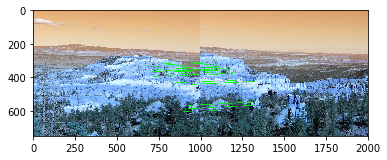

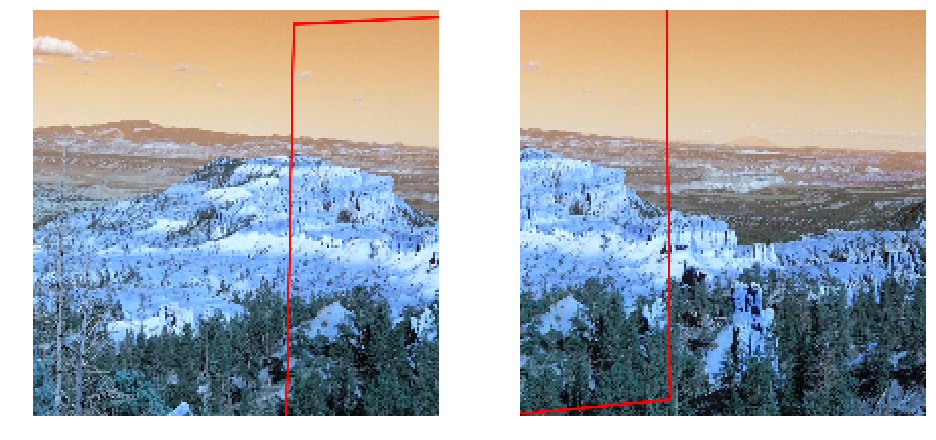

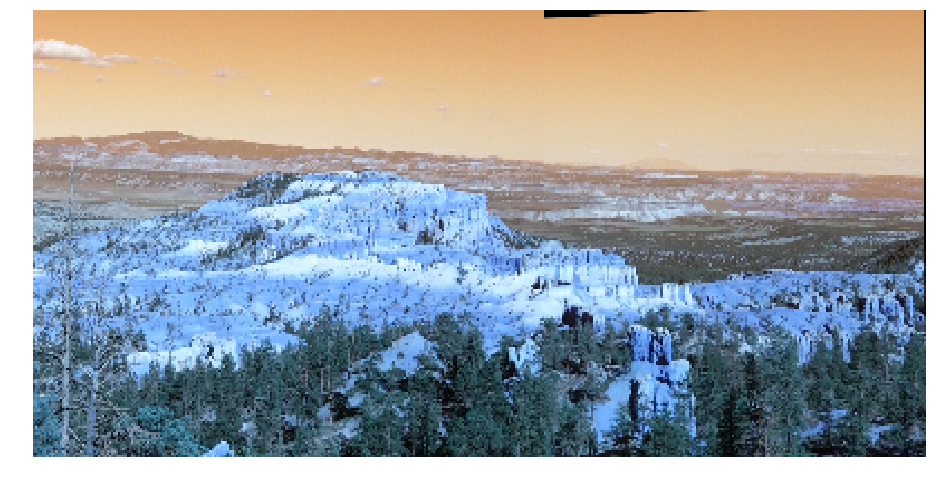

In [20]:
# Case 1 Hill top

# Load images
img_list = []
for i in range(1,3):
    im = cv2.imread(os.path.join(test_dir,'img1_{}.png'.format(i)))
    img_list.append(im)

M = get_transformation(img_list) 
final_img = stitching(img_list,M)
final_img = remove_black(final_img)

cv2.imwrite(os.path.join(save_dir,'final_img_1.png'),final_img)

final_img = cv2.resize(final_img,(400,200))
fig = plt.figure(figsize=(16,16))
plt.imshow(final_img)
plt.axis('off')
plt.show()


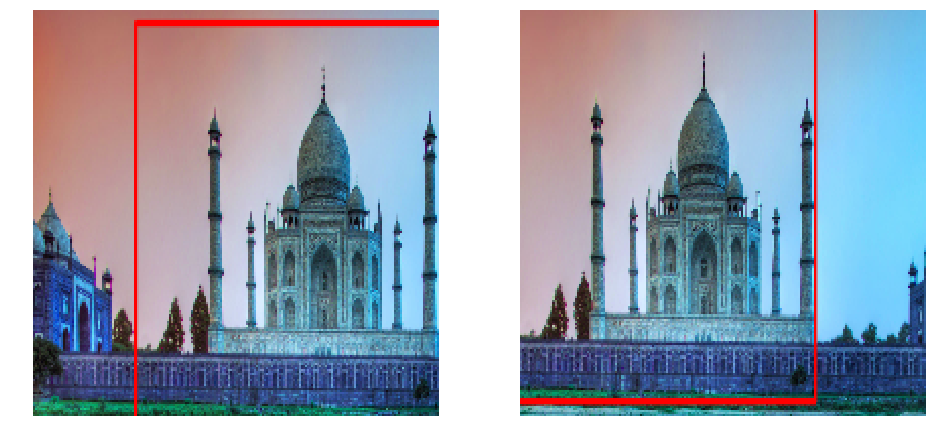

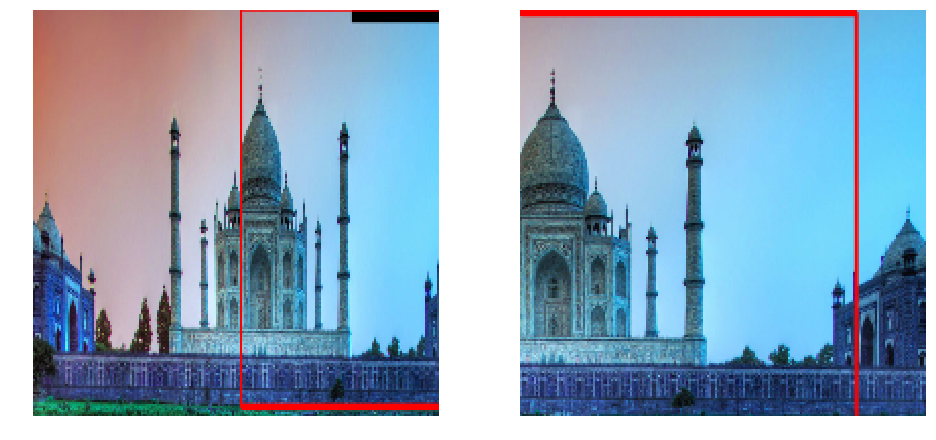

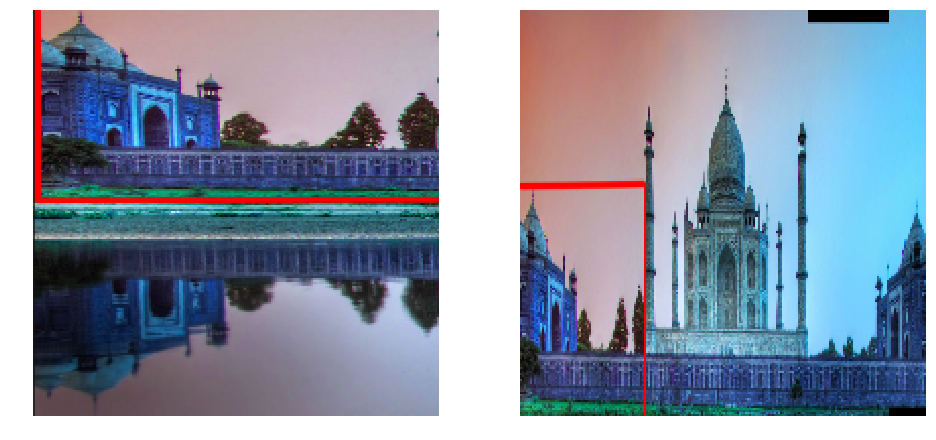

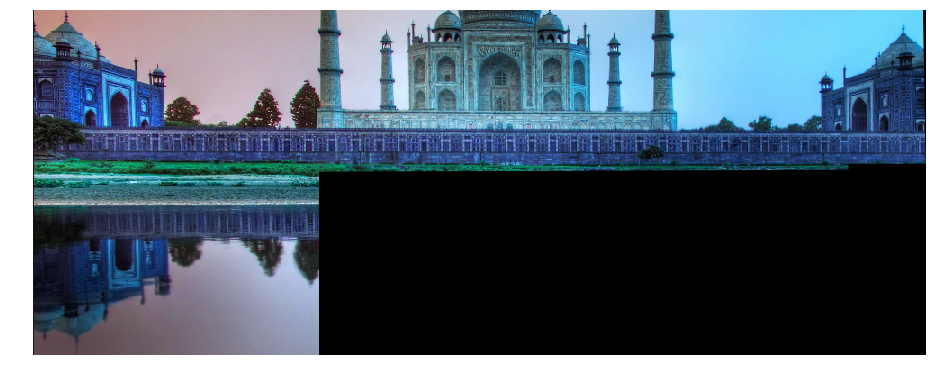

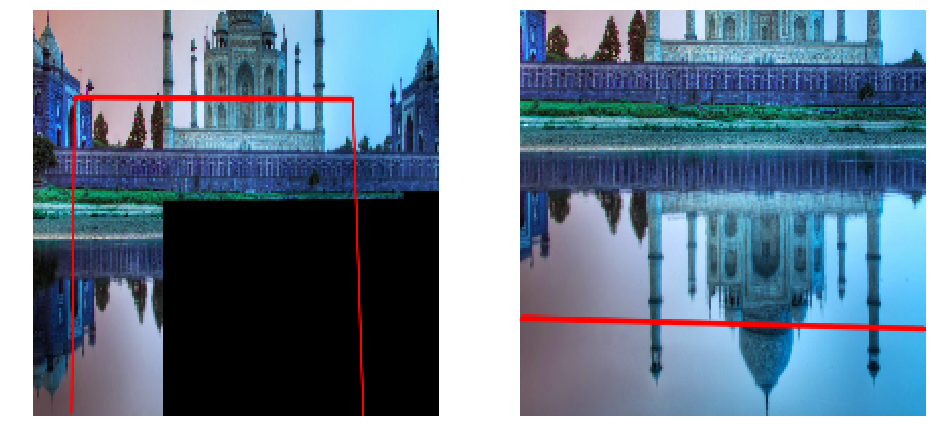

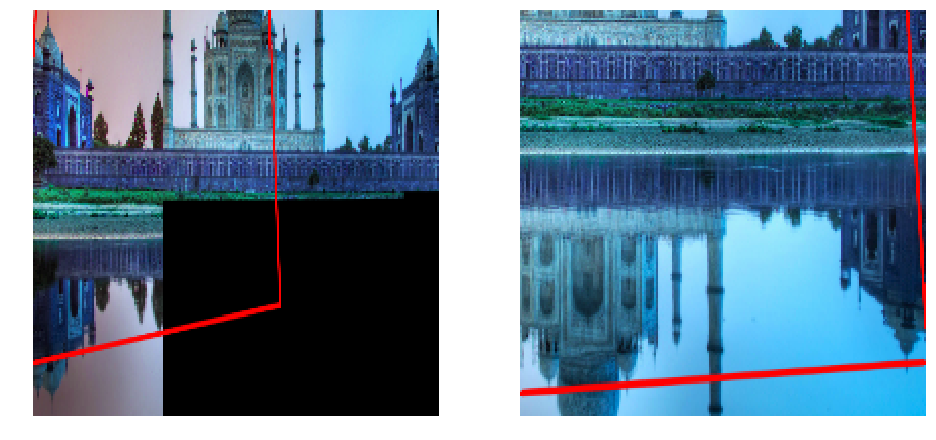

True

In [225]:
# Case 2 Taj Mahal

# Load images
img_list = []
for i in range(1,7):
    im = cv2.imread(os.path.join(test_dir,'img2_{}.png'.format(i)))
    img_list.append(im)

# 1 & 2    
M = get_transformation(img_list[0:2]) 
final_img = stitching(img_list,M)
final_img = remove_black(final_img)

# fig = plt.figure(figsize=(16,16))
# plt.imshow(final_img)
# plt.axis('off')
# plt.show()

# 3
M = get_transformation([final_img,img_list[2]]) 
final_img = stitching([final_img,img_list[2]],M)
final_img = remove_black(final_img)

# fig = plt.figure(figsize=(16,16))
# plt.imshow(final_img)
# plt.axis('off')
# plt.show()

# 4
M = get_transformation([img_list[3],final_img]) 
final_img = stitching([img_list[3],final_img],M)
final_img = remove_black(final_img)

fig = plt.figure(figsize=(16,16))
plt.imshow(final_img)
plt.axis('off')
plt.show()

# 5
M = get_transformation([final_img,img_list[4]]) 
final_img = stitching([final_img,img_list[4]],M)
final_img = remove_black(final_img)

# fig = plt.figure(figsize=(16,16))
# plt.imshow(final_img)
# plt.axis('off')
# plt.show()


# 6
M = get_transformation([final_img,img_list[5]]) 
final_img = stitching([final_img,img_list[5]],M)
final_img = remove_black(final_img)

# fig = plt.figure(figsize=(16,16))
# plt.imshow(final_img)
# plt.axis('off')
# plt.show()


cv2.imwrite(os.path.join(save_dir,'final_img_2.png'),final_img)    




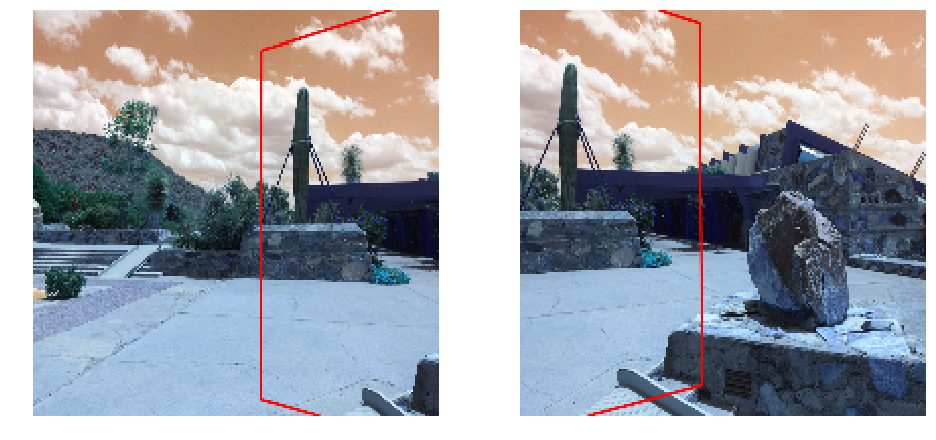

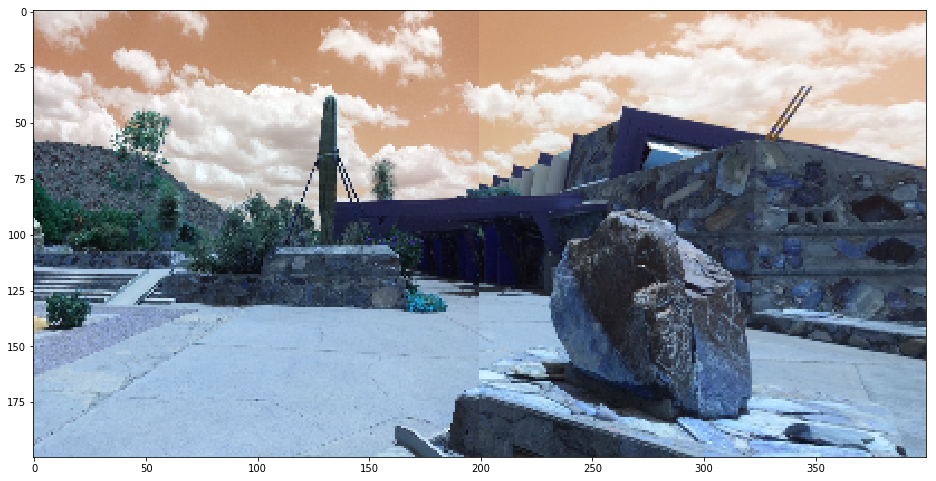

In [227]:
# Case 3 Cactus

# Load images
img_list = []
for i in range(1,3):
    im = cv2.imread(os.path.join(test_dir,'img3_{}.png'.format(i)))
    img_list.append(im)
    
M = get_transformation(img_list)
# Stitch images
cv2.imwrite(os.path.join(save_dir,'final_img_3.png'),final_img)

final_img = stitching(img_list,M)

final_img = cv2.resize(final_img,(400,200))

fig = plt.figure(figsize=(16,16))
plt.imshow(final_img)
plt.show()


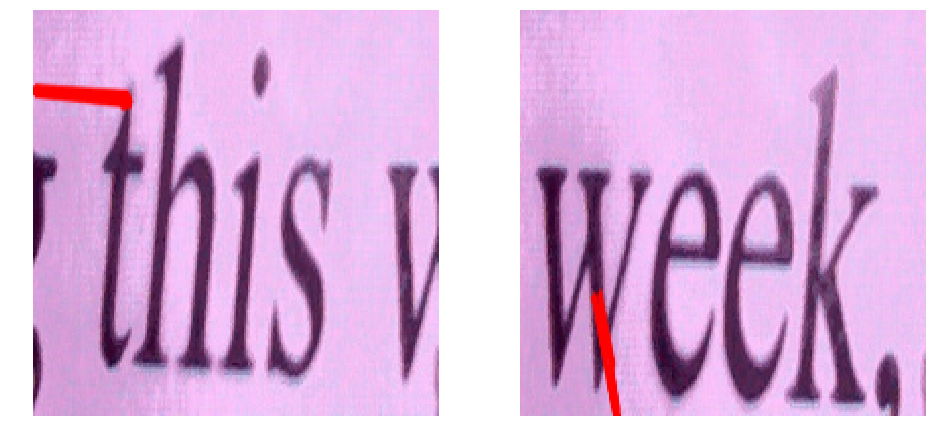

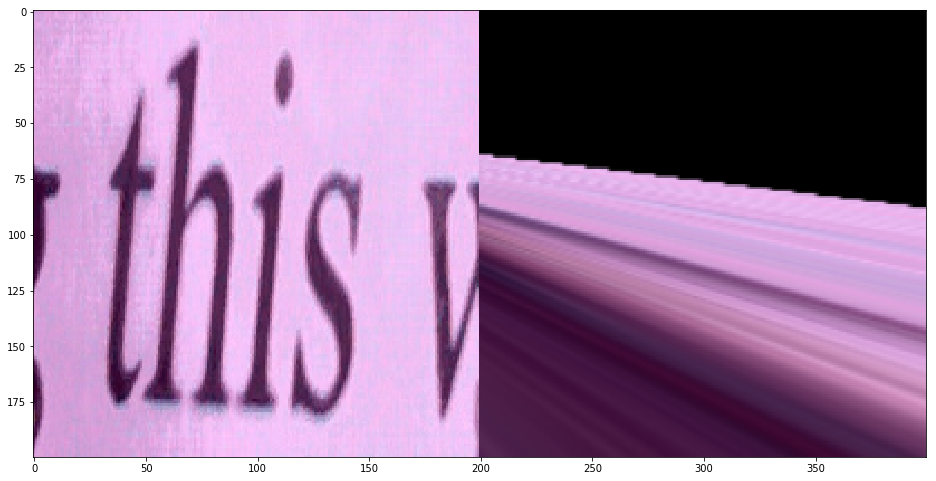

In [228]:
# Case 4 Text

# Load images
img_list = []
for i in range(1,3):
    im = cv2.imread(os.path.join(test_dir,'img4_{}.jpg'.format(i)))
    img_list.append(im)

M = get_transformation(img_list)
# Stitch images
final_img = stitching(img_list,M)

cv2.imwrite(os.path.join(save_dir,'final_img_4.png'),final_img)
final_img = cv2.resize(final_img,(400,200))

fig = plt.figure(figsize=(16,16))
plt.imshow(final_img)
plt.show()

